In [1]:
import numpy as np
import pandas as pd
import ms_feature_validation as mfv
import bokeh.plotting
bokeh.plotting.output_notebook()
import matplotlib.pyplot as plt

Loading BokehJS ...

In [40]:
data = mfv.fileio.read_progenesis("../examples/SuerosRCC_ESi_neg_default_SepOct2017.csv")

# adding order and batch information
temp = pd.Series(data=data.sample_metadata.index.str.split("_"),
                 index=data.sample_metadata.index)
order = temp.apply(lambda x: x[-1]).astype(int)
dates = temp.apply(lambda x: x[1])
dates_to_batch = dict(zip(dates.unique(), range(1, dates.size + 1)))
batch = (temp.apply(lambda x: dates_to_batch[x[1]])).astype(int)

def convert_to_global_run_order(order, batch):
    max_order = order.groupby(batch).max()
    max_order[0] = 0
    max_order = max_order.sort_index()
    max_order = max_order.cumsum()
    global_run_order = order + batch.apply(lambda x: max_order[x - 1])
    return global_run_order

data.order = convert_to_global_run_order(order, batch)
data.batch = batch
data.id = data.sample_metadata.index

# setup sample types
sample_mapping = {"qc": ["QC"],
                  "blank": ["SV"],
                  "sample": ["CS", "EI", "EII", "EIII", "EIV", "EI2", "EII2",
                             "EIII2", "EIV2", "Crb", "Pa"]}
data.mapping = sample_mapping

In [41]:
cr = mfv.filter.ClassRemover(["Sarc", "B", "O", "Onc", "EII2", "Pa"])
bc = mfv.filter.BlankCorrector()
pf = mfv.filter.PrevalenceFilter(lb=0.8)
vf = mfv.filter.VariationFilter(ub=0.25)
pipeline = mfv.filter.Pipeline([cr, bc, pf, vf], verbose=True)
pipeline.process(data)
rm_cols = data.data_matrix.columns.difference(data.data_matrix.columns[220:240])
data.remove(rm_cols, axis="features") 
data.sample_metadata = data.sample_metadata.sort_values("order")
data.data_matrix = data.data_matrix.loc[data.sample_metadata.index, :]

# batch_checker = mfv.filter.BatchSchemeChecker()
# batch_checker.process(data)
# batch_prevalence = mfv.filter.BatchPrevalenceChecker()
# batch_prevalence.process(data)

Applying None: 0 features removed, 28 samples removed, Mean CV reduced by 3.51 %.
Applying Blank Corrector: 0 features removed, 0 samples removed, Mean CV reduced by -36.73 %.
Applying Prevalence Filter: 705 features removed, 0 samples removed, Mean CV reduced by 27.62 %.
Applying Variation Filter: 8698 features removed, 0 samples removed, Mean CV reduced by 9.66 %.


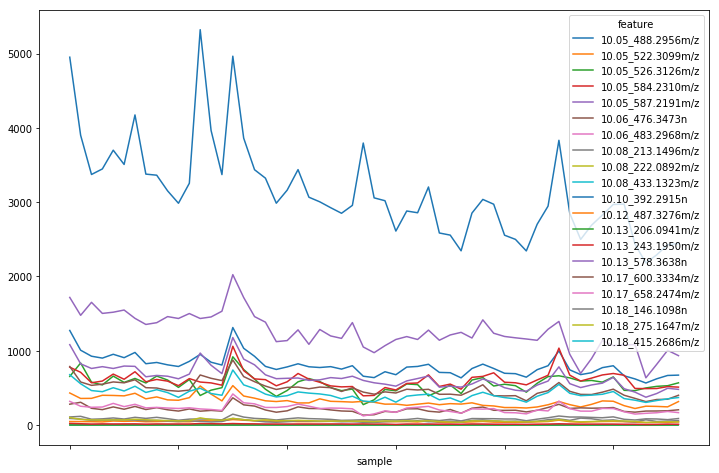

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
data.data_matrix[data.classes == "QC"].plot(ax=ax)

In [44]:
batch_corrector = mfv.filter.BatchCorrector(n_min=4)
batch_corrector.process(data)

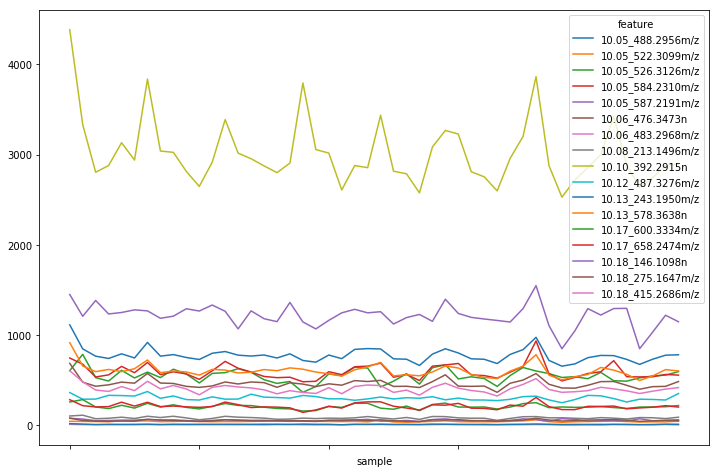

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
data.data_matrix[data.classes == "QC"].plot(ax=ax)

In [46]:
data.plot.pca_scores(color_by="type");